# Construction d'un index sur les mots 

In [1]:
from src.building_index_words import *

# Téléchargement des ressources NLTK nécessaires
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc190\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc190\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pc190\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Chargement des données

In [2]:
# 1. Chargement des données
input_file = "articles_processed.pkl"
print("1. Chargement des données...")
df = load_processed_data(input_file)

1. Chargement des données...
Données chargées avec succès. Shape: (23702, 11)


## Préparation des textes

In [3]:
# 2. Préparation des textes
print("\n2. Préparation des textes...")
texts = prepare_texts(df)


2. Préparation des textes...


Préparation des textes: 100%|██████████| 23702/23702 [00:00<00:00, 48165.10it/s]


## Création des vectoriseurs

In [4]:
# 3. Création des vectoriseurs
print("\n3. Création des vectoriseurs...")
# différentes configurations possible
vectorizers = create_vectorizers(min_df=5, max_df=0.95, use_stemming=True)
# Alternative avec lemmatisation: vectorizers = create_vectorizers(min_df=5, max_df=0.95, use_stemming=False)



3. Création des vectoriseurs...


## Création des matrices documents-termes

In [5]:
# 4. Création des matrices documents-termes
print("\n4. Création des matrices documents-termes...")
dtm_results = create_document_term_matrices(texts, vectorizers)


4. Création des matrices documents-termes...
Création de la matrice documents-termes avec tf...


c:\Users\pc190\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\pc190\Anaconda\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'analysi', 'ani', 'base', 'becaus', 'befor', 'doe', 'dure', 'figur', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'propos', 'result', 'studi', 'tabl', 'themselv', 'thi', 'use', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


  Forme de la matrice: (23702, 7666)
  Taille du vocabulaire: 7666
  Densité de la matrice: 0.0053
Création de la matrice documents-termes avec tfidf...
  Forme de la matrice: (23702, 7666)
  Taille du vocabulaire: 7666
  Densité de la matrice: 0.0053


## Analyse du vocabulaire

In [6]:
# 5. Analyse du vocabulaire
print("\n5. Analyse du vocabulaire...")
analysis_results = analyze_vocabulary(dtm_results)


5. Analyse du vocabulaire...

Les 20 termes les plus fréquents (tf):
           term  frequency
6814        thi      19590
7247        use      17318
543        base      13160
4174      model      11987
6655     system      11822
5245     propos      11039
4400    network       9738
4337          n       8572
171   algorithm       8339
5661     result       8300
4873    perform       7612
6862       time       7337
5376          r       7015
5200    problem       6620
1213     comput       5730
3288     inform       5530
6482      studi       5462
1693     design       5336
2720      gener       5298
3679      learn       5290

Nombre total d'occurrences de termes: 1477961
Nombre de termes uniques: 7666

Les 20 termes les plus fréquents (tfidf):
           term   frequency
6655     system  534.330438
7247        use  529.053662
4174      model  524.156067
543        base  513.955637
4400    network  497.031071
6814        thi  450.501806
171   algorithm  381.772475
3679      learn  3

## Visualisation des fréquences de termes


6. Visualisation des fréquences de termes...


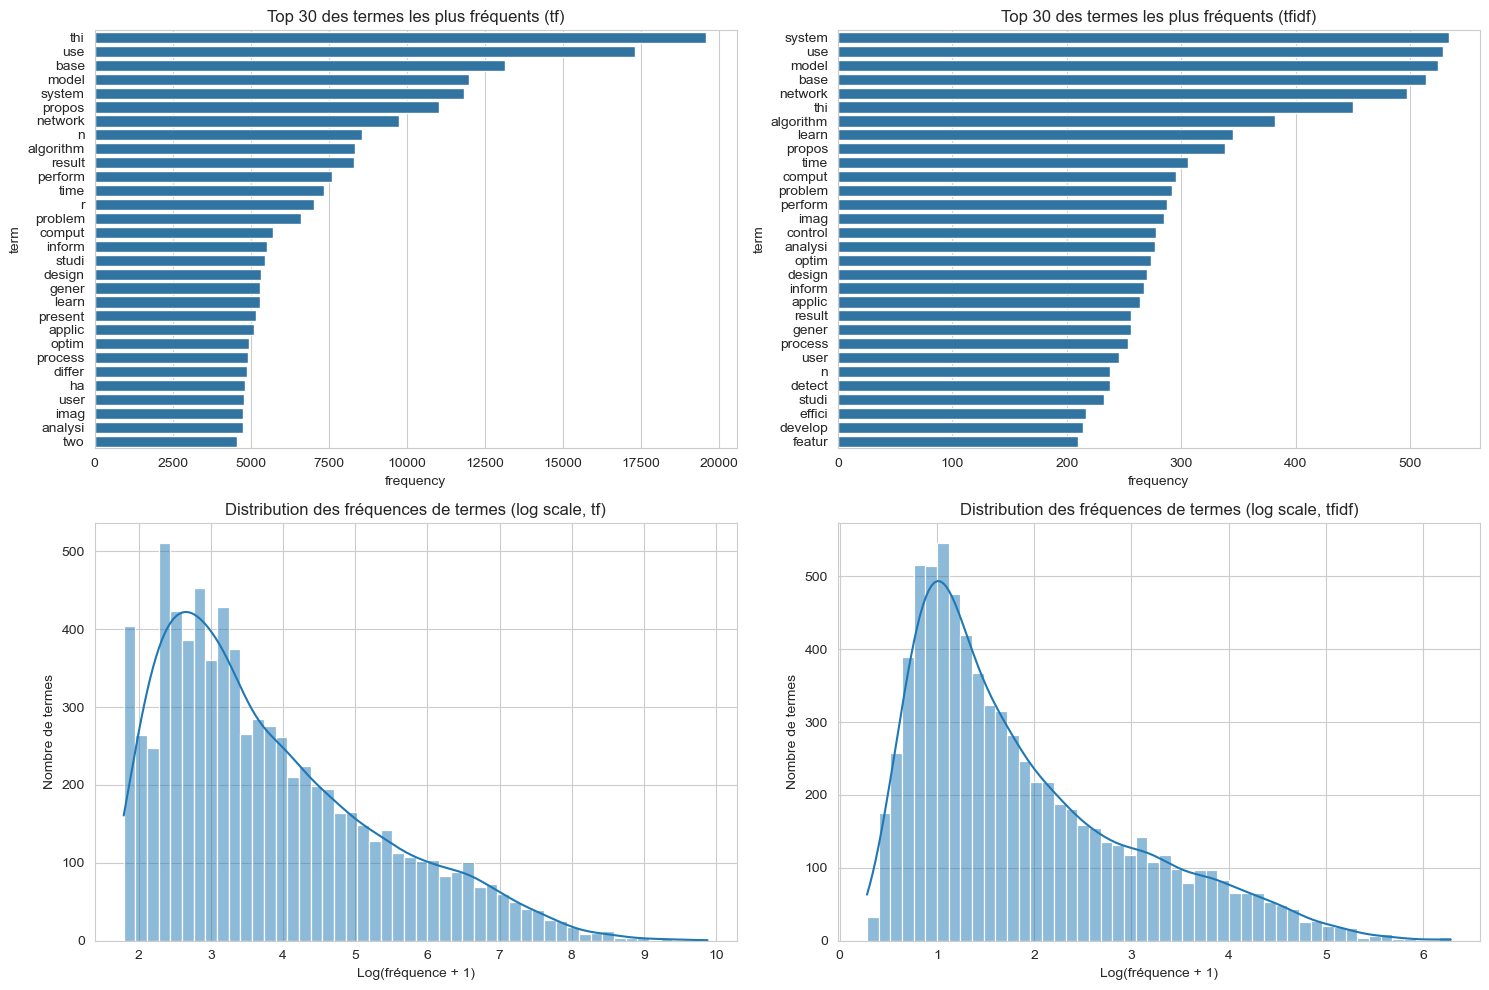

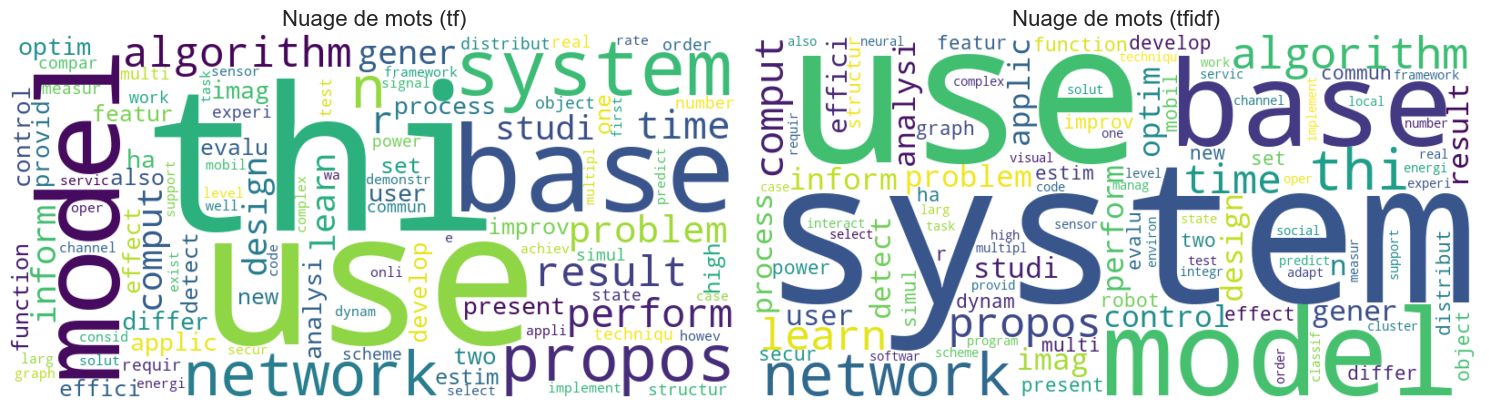

In [7]:
# 6. Visualisation des fréquences de termes
print("\n6. Visualisation des fréquences de termes...")
visualize_term_frequencies(analysis_results)

## Visualisation des documents - tsne


7. Visualisation des documents dans un espace réduit...


c:\Users\pc190\Anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\pc190\Anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


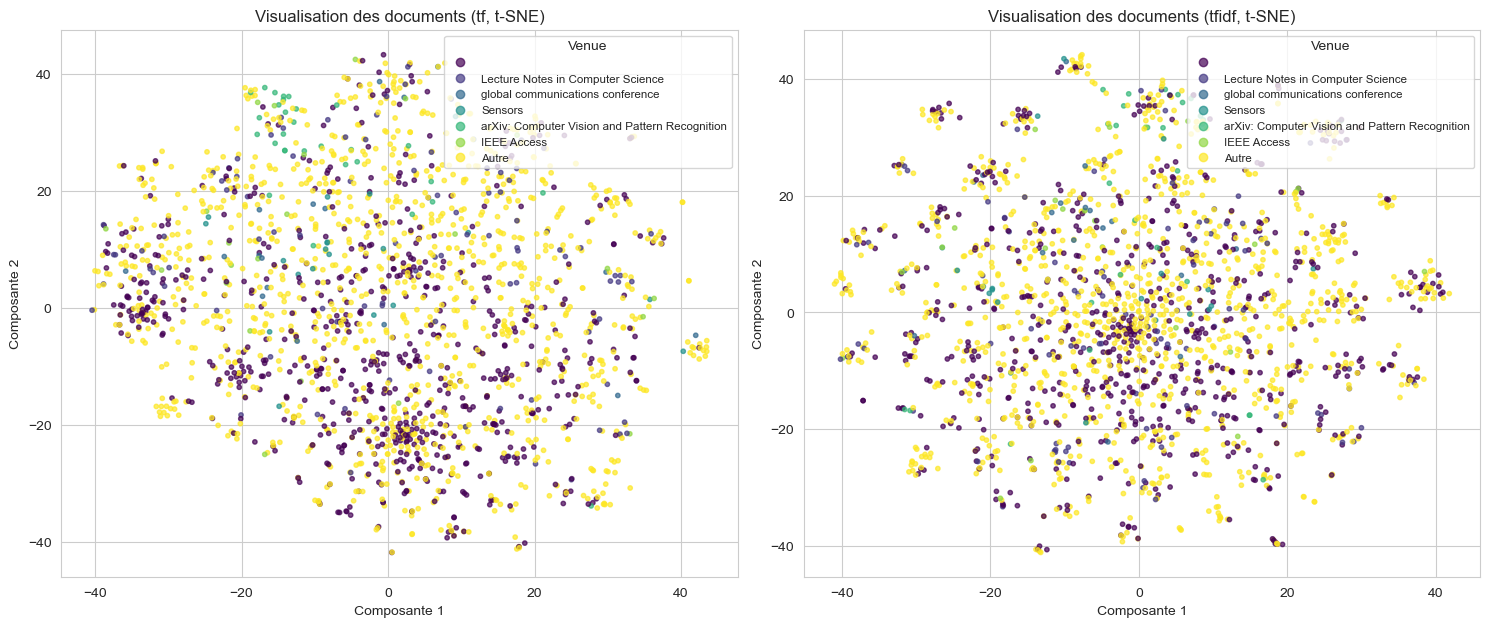

In [8]:
# 7. Visualisation des documents
print("\n7. Visualisation des documents dans un espace réduit...")
# Vous pouvez tester différentes méthodes: 'pca', 'svd', 'tsne'
visualize_document_vectors(dtm_results, df, method='tsne', sample_size=2000)

## Visualisation des documents - svd


7. Visualisation des documents dans un espace réduit...


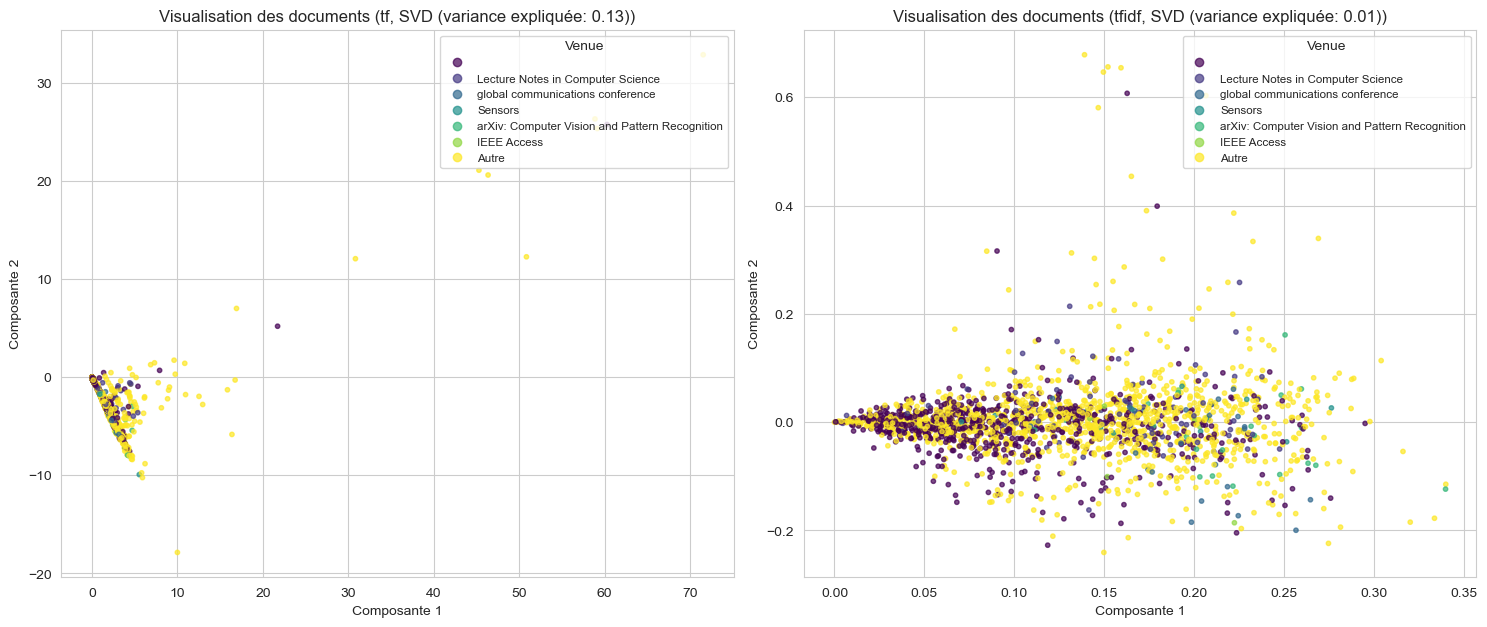

In [9]:
# 7. Visualisation des documents
print("\n7. Visualisation des documents dans un espace réduit...")
visualize_document_vectors(dtm_results, df, method='svd', sample_size=2000)

## Visualisation des documents - pca


7. Visualisation des documents dans un espace réduit...


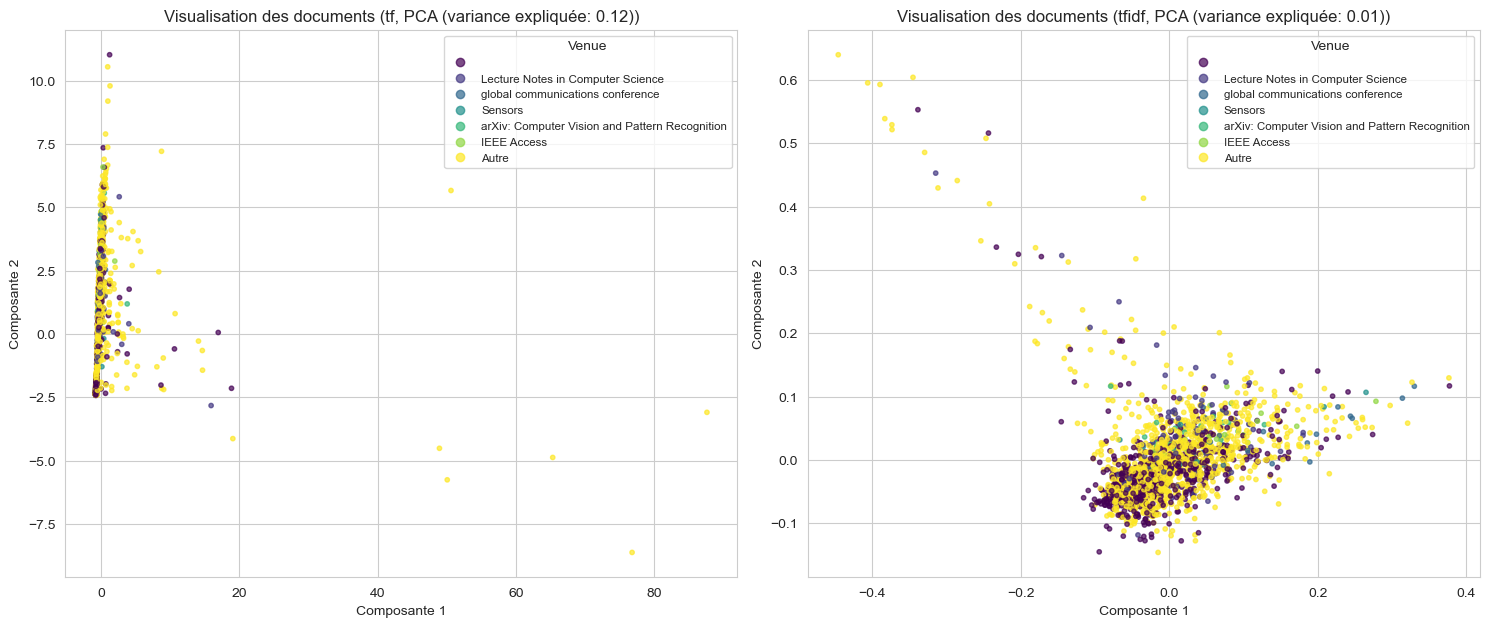

In [10]:
# 7. Visualisation des documents
print("\n7. Visualisation des documents dans un espace réduit...")
visualize_document_vectors(dtm_results, df, method='pca', sample_size=2000)